In [8]:
#(1) 데이터 가져오기
#터미널에서 ~/data/data/bike-sharing-demand 경로에 train.csv 데이터를 train 변수로 가져 옵니다.
#여기에서 데이터를 상세히 확인할 수 있습니다.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#sample_df = pd.read_csv('./data/bike-sharing-demand/sampleSubmission.csv')
train_df = pd.read_csv('./data/bike-sharing-demand/train.csv')
test_df = pd.read_csv('./data/bike-sharing-demand/test.csv')
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [10]:
#(2) datetime 컬럼을 datetime 자료형으로 변환하고 연, 월, 일, 시, 분, 초까지 6가지 컬럼 생성하기
#to_datetime 활용 : 링크 참조
#pandas datetime extract year month day 키워드로 검색해 보기

train_df['datetime'] = pd.to_datetime(train_df['datetime'])
train_df['year'] = train_df['datetime'].dt.year
train_df['month'] = train_df['datetime'].dt.month
train_df['day'] = train_df['datetime'].dt.day
train_df['hour'] = train_df['datetime'].dt.hour
train_df['minute'] = train_df['datetime'].dt.minute
train_df['second'] = train_df['datetime'].dt.second

train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


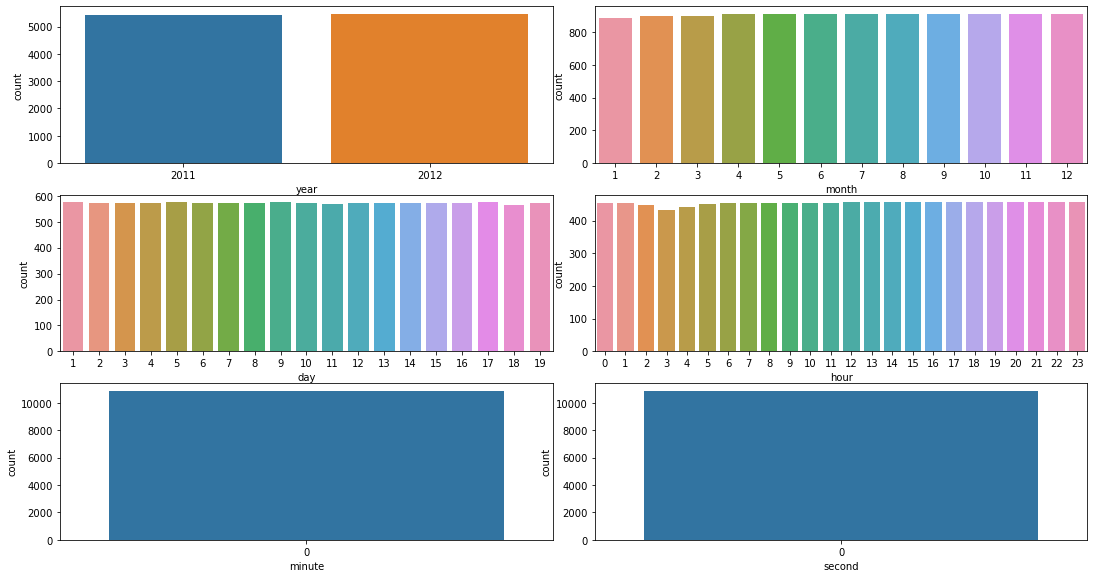

In [3]:
#(3) year, month, day, hour, minute, second 데이터 개수 시각화하기
#sns.countplot 활용해서 시각화하기
#subplot을 활용해서 한 번에 6개의 그래프 함께 시각화하기

fig, axes = plt.subplots(3, 2, figsize=(15, 8))
fig.tight_layout()

sns.countplot(x="year", data=train_df, ax=axes[0,0])
sns.countplot(x="month", data=train_df, ax=axes[0,1])
sns.countplot(x="day", data=train_df, ax=axes[1,0])
sns.countplot(x="hour", data=train_df, ax=axes[1,1])
sns.countplot(x="minute", data=train_df, ax=axes[2,0])
sns.countplot(x="second", data=train_df, ax=axes[2,1])
plt.show()

In [4]:
train_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'second'],
      dtype='object')

In [12]:
train_target = train_df['count']

drop_columns = ['datetime','casual','registered','count']
train = train_df.drop(drop_columns, axis=1)


(array([4284., 2337., 1686., 1067.,  633.,  426.,  233.,  116.,   85.,
          19.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <BarContainer object of 10 artists>)

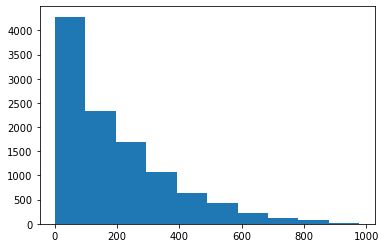

In [13]:
plt.hist(train_target)
#한쪽으로 퍼진 분포

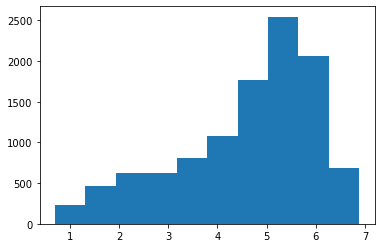

count    10886.000000
mean         4.591364
std          1.419454
min          0.693147
25%          3.761200
50%          4.983607
75%          5.652489
max          6.885510
Name: count, dtype: float64

In [14]:
#한 쪽으로 몰려있는 분포에 로그 변환 -> 넓게 퍼짐
count_log = np.log1p(train_target)
plt.hist(count_log)
plt.show()

count_log.describe()

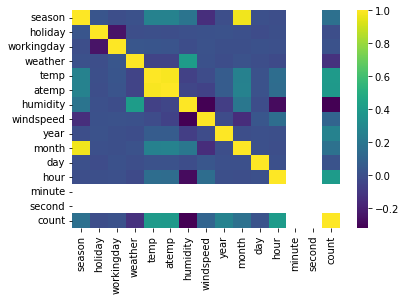

season        0.163439
holiday      -0.005393
workingday    0.011594
weather      -0.128655
temp          0.394454
atemp         0.389784
humidity     -0.317371
windspeed     0.101369
year          0.260403
month         0.166862
day           0.019826
hour          0.400601
minute             NaN
second             NaN
count         1.000000
Name: count, dtype: float64


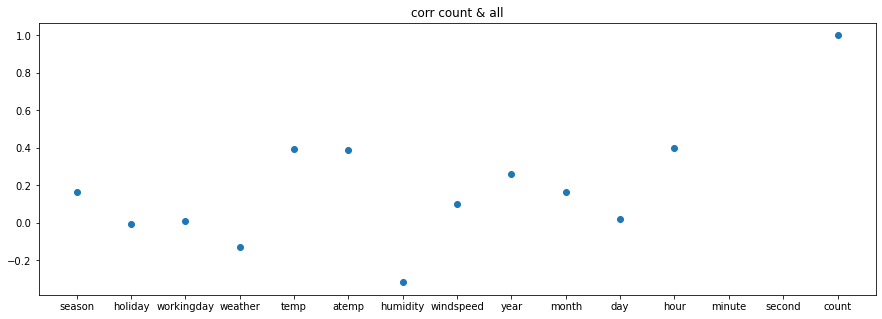

In [8]:
#(4) X, y 컬럼 선택 및 train/test 데이터 분리
#X(feature) 에는 어떤 데이터 컬럼을 넣어야 될지 고민해 봅시다 데이터 컬럼을 추가하거나 빼면서 잘 조합하여 데이터를 넣기 
#만일 모든 데이터 컬럼(특징)을 넣는다면 오차 값이 말도 안 되게 적게 나올 수도 있습니다.
#ex) count를 예측하는데 casual,registered 컬럼이 필요할까요?

#상관성 분석

feature = ['season', 'holiday', 'workingday', 'weather', 'temp','atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour', 'minute', 'second' ]
feature1 = feature
feature1.append('count')

corr = train_df[feature1].corr()

sns.heatmap(corr, cmap='viridis')
plt.show()

print(corr['count'])
plt.figure(figsize=(15,5))
plt.scatter(feature,corr['count'])
plt.title('corr count & all')
plt.show()

In [18]:
print(train.shape)
train_target.shape

(10886, 14)


(10886,)

In [19]:
# One Hot Encoding 
train_onehot = pd.get_dummies(train, columns=['season', 'weather', 'year', 'month', 'day', 'hour'])
train_onehot

,holiday,workingday,temp,atemp,humidity,windspeed,minute,second,season_1,season_2,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0,0,9.84,14.395,81,0.0000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,9.02,13.635,80,0.0000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,9.02,13.635,80,0.0000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,9.84,14.395,75,0.0000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,9.84,14.395,75,0.0000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,0,1,15.58,19.695,50,26.0027,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10882,0,1,14.76,17.425,57,15.0013,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10883,0,1,13.94,15.910,61,15.0013,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10884,0,1,13.94,17.425,61,6.0032,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [20]:
#count 값을 맞추고자 하므로, y 변수에 count 컬럼의 데이터 넣기
X = train_onehot
y = count_log


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=220)

In [22]:
#(5) LinearRegression 모델 학습
#sklearn의 LinearRegression 모델 불러오기 및 학습하기
model = LinearRegression()

#학습
model.fit(X_train, y_train)

LinearRegression()

In [23]:
print("가중치 :", model.coef_)
print("편향 :", model.intercept_)

print("훈련세트 정확도: {:.2f}".format( model.score(X_train, y_train) ))
print("테스트세트 정확도: {:.2f}".format( model.score(X_test, y_test) ))
y_pred = model.predict(X_test)
print("r2_score:", r2_score(y_test, y_pred))

가중치 : [-8.87482681e-02 -8.29806234e-02  8.19013168e-03  1.56331700e-02
 -3.02945539e-03 -2.94835437e-03 -2.71991281e+09 -4.13588943e+09
 -2.30353062e+10 -5.60916623e+10 -4.94757902e+10 -5.02786864e+10
  1.07544645e+10  1.07544645e+10  1.07544645e+10  1.07544645e+10
 -5.78925041e+08 -5.78925041e+08 -2.47270866e+10 -2.47270866e+10
 -2.47270866e+10  8.32926951e+09  8.32926951e+09  8.32926951e+09
  1.71339746e+09  1.71339746e+09  1.71339746e+09  2.51629359e+09
  2.51629359e+09  2.51629359e+09 -5.18592502e+08 -5.18592502e+08
 -5.18592502e+08 -5.18592502e+08 -5.18592502e+08 -5.18592502e+08
 -5.18592502e+08 -5.18592502e+08 -5.18592502e+08 -5.18592502e+08
 -5.18592502e+08 -5.18592502e+08 -5.18592502e+08 -5.18592502e+08
 -5.18592502e+08 -5.18592502e+08 -5.18592502e+08 -5.18592502e+08
 -5.18592502e+08  5.65676773e+09  5.65676773e+09  5.65676773e+09
  5.65676773e+09  5.65676773e+09  5.65676773e+09  5.65676773e+09
  5.65676773e+09  5.65676773e+09  5.65676773e+09  5.65676773e+09
  5.65676773e+09  5

In [24]:
#(6) 학습된 모델로 X_test에 대한 예측값 출력 및 손실함수값 계산
#학습된 모델에 X_test를 입력해서 예측값 출력하기
print("예측값 :", y_pred)

#모델이 예측한 값과 정답 target 간의 손실함수 값 계산하기
#mse 값과 함께 rmse 값도 계산하기

MSE = mean_squared_error(y_test, y_pred)
RMSE = MSE**0.5

print("MSE :", MSE)
print("RMSE :", RMSE)

#RMSE 값 150 이하를 달성

예측값 : [5.2023201  1.26758575 4.11244583 ... 4.83176422 5.1453743  5.18959808]
MSE : 0.3329632897861798
RMSE : 0.5770297130877922


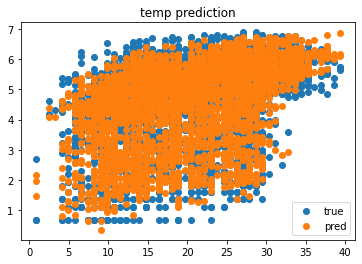

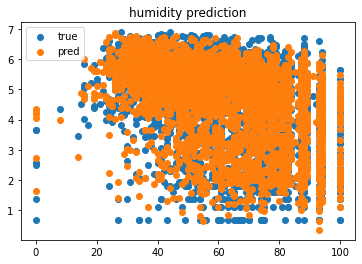

In [25]:
#(7) x축은 temp 또는 humidity로, y축은 count로 예측 결과 시각화하기
#x축에 X 데이터 중 temp 데이터를, y축에는 count 데이터를 넣어서 시각화하기
plt.scatter(X_test.temp, y_test, label="true")
plt.scatter(X_test.temp, y_pred, label="pred")
plt.title('temp prediction')
plt.legend()
plt.show()
#x축에 X 데이터 중 humidity 데이터를, y축에는 count 데이터를 넣어서 시각화하기
plt.scatter(X_test.humidity, y_test, label="true")
plt.scatter(X_test.humidity, y_pred, label="pred")
plt.title('humidity prediction')
plt.legend()
plt.show()